# Analyzing SOFC data (parts 2 and 3)

## 2) Leave-k-out cross-validation
In the previous notebook, I attempted to analyze the ~100 data points by splitting the data set into 60/20/20 ratios of training, cross-validation, and test data. This led to a model that overfit the data because there were too few data points to make a generalizable model.

Here I will use the leave-k-out cross validation technique, which generates k models from k test sets with n-k training examples in each set and k test examples in each set. These models are averaged to produce a more generalized model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import pandas as pd
import time
%matplotlib inline
from sklearn import cross_validation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

from sofc_func import *

I did learn that the characteristics to be looking at are electron affinity and d-electron count and that the form is a polynomial function. I will import the data and run a cross validation using a polynomial model.

In [2]:
# Import using pandas
df = pd.read_csv("data.csv")

# Clean out rows where there is no parent A or parent B

data = df[pd.notnull(df['A_par']) & pd.notnull(df['B_par']) & pd.notnull(df['d_star']) & pd.notnull(df['k_star']) 
             & pd.notnull(df['e affinity(B)']) & pd.notnull(df['d-electron count (B)'])]

# Split into training and test sets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

#Disable flag
pd.options.mode.chained_assignment = None

data['dk_star'] = pd.Series(dk_star(data,1000), index=data.index)

Y = np.array(data[ ['dk_star'] ])
X = np.array(data[ ['e affinity(B)', 'd-electron count (B)'] ])


###Leave k out cross-validation:
I will look at average model score as a function of k. Remember, larger k means larger test sets and smaller training sets. Larget k also means more iterations/scores to average.

Because the scores are subject to noise from random sampling of the data sets, I will loop through the exercise 100 times and average the results.

In [3]:
optimize_k(300, len(data), X, Y)

NameError: global name 'plt' is not defined

The cross-validation is optimized at **k=4**. I will now examine the polynomial fit as I did in the previous notebook.

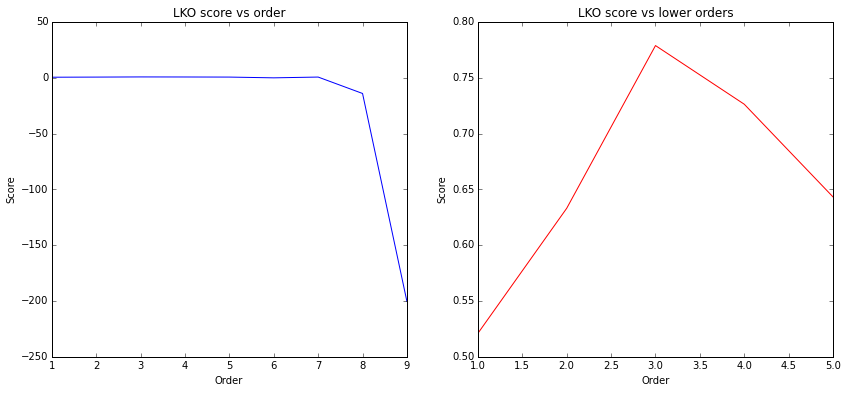

Polynomial order optimization executed in: 9.244641s


In [51]:
optimize_order(200, len(data), 4, X,Y)

### The model is optimized with a third order polynomial using k=3 leave-k-out cross-validation.
This result is much more believable than the one from the previous notebook because third order functions can be physically justified. I will now create an averaged model using these parameters and 200 iterations.

In [52]:
get_scores(500, 4,3,len(data),X,Y)

Average score of this model: 0.775542699847
Standard deviation of scores: 0.0282197686363


###EN and d-electron count explain about 3/4 of the variation in the data. Where does the rest of it come from?
In the previous notebook I started to explore categorical variables, but never got to their analysis. I will not revisit the material family, sample type, and measurement type categories. Note that I expect measurement type to explain no real variance because measurements should not depend on the method of collection.

## 3) Categorical variables:

Remember how the three families of materials looked clustered in the previous notebook? The sets of Ruddlesden-Popper and double perovskite materials each had very small ranges for electronegativity of the B-site cation, but this model isn't taking material family into consideration.

Ruddlesden-Popper phases have structures that are more conducive to a higher D\*k\* and double perovskites order into structures that also exhibit large D\*k\*. Surely this categorization should explain some of the variability.

Another category that may have an effect is sample type. Thin film and single crystals are much cleaner than ceramic samples, which often translates to higher D\*k\* because they aren't hindered by problems in grain orientation.

###I will dummy code again

In [53]:
# Dummy code 'family' column
f = pd.get_dummies(data['family'], prefix='family')
m = pd.get_dummies(data['measurement_type'], prefix='m')
s = pd.get_dummies(data['sample_type'], prefix='s')

data = data.drop('family', axis=1)
data = data.drop('measurement_type', axis=1)
data = data.drop('sample_type', axis=1)

data = pd.concat([data, f], axis=1)
data = pd.concat([data, m], axis=1)
data = pd.concat([data, s], axis=1)

###Material family:

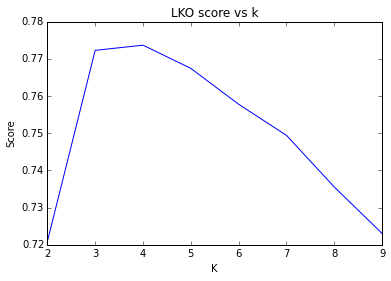

k optmization executed in: 17.010943s


In [54]:
#X = np.array(data[ ['d-electron count (B)', 'e affinity(B)', 'family_Perovskite', 
#           'family_Ruddlesden-Popper', 'family_Double Perovskite', 
#          'm_IEDP/SIMS', 'm_ECR', 'm_EBSP',
#          's_Ceramic', 's_Single Crystal', 's_Thin Film'
#          ]])

X = np.array(data[ ['d-electron count (B)', 'e affinity(B)', 'family_Perovskite', 
          'family_Ruddlesden-Popper', 'family_Double Perovskite']])
Y_mean = np.mean(data[ ['dk_star'] ].values)
#Y = data[ ['dk_star'] ] - Y_mean
Y = np.array(data[ ['dk_star'] ])

optimize_k(200, len(X), X,Y)

The leave-k-out algorithm is again optimized at **k=4**.

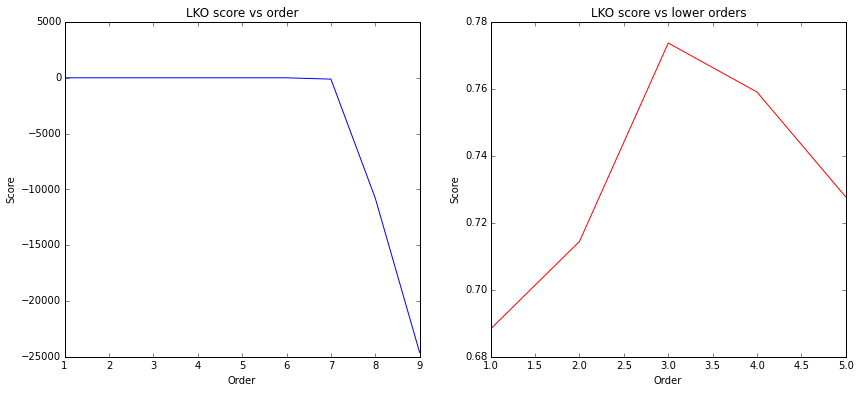

Polynomial order optimization executed in: 62.007249s


In [55]:
optimize_order(100, len(X), 4, X, Y)

Same order as before. I'll look at the score for k=4,O=3:

In [56]:
get_scores(500,4,3,len(X),X,Y)

Average score of this model: 0.773173430463
Standard deviation of scores: 0.0313494522966


###Material family has no effect on the model's performance.

###Sample type:

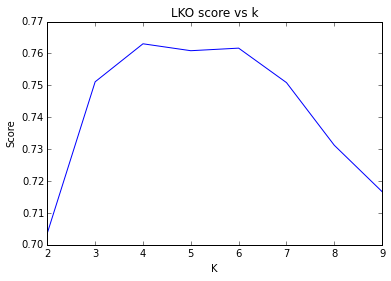

k optmization executed in: 16.295498s


In [57]:
#X = np.array(data[ ['d-electron count (B)', 'e affinity(B)', 'family_Perovskite', 
#           'family_Ruddlesden-Popper', 'family_Double Perovskite', 
#          'm_IEDP/SIMS', 'm_ECR', 'm_EBSP',
#          's_Ceramic', 's_Single Crystal', 's_Thin Film'
#          ]])

X = np.array(data[ ['d-electron count (B)', 'e affinity(B)', 's_Ceramic', 
          's_Single Crystal', 's_Thin Film']])
Y_mean = np.mean(data[ ['dk_star'] ].values)
#Y = data[ ['dk_star'] ] - Y_mean
Y = np.array(data[ ['dk_star'] ])

optimize_k(200, len(X), X,Y)

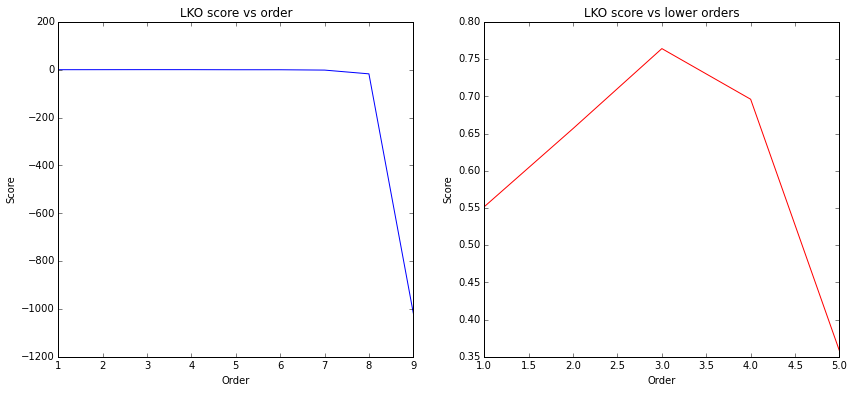

Polynomial order optimization executed in: 61.344885s


In [58]:
optimize_order(100, len(X), 4, X, Y)

In [59]:
get_scores(500,4,3,len(X),X,Y)

Average score of this model: 0.767142855875
Standard deviation of scores: 0.0374197439163


###Sample type has no effect on model performance.

###Measurement type:
(I expect this to have no effect)

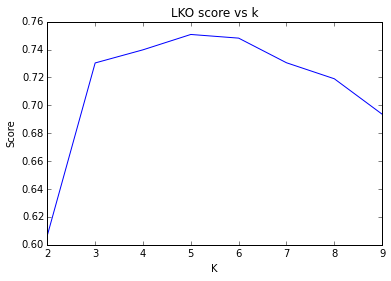

k optmization executed in: 17.773436s


In [60]:
#X = np.array(data[ ['d-electron count (B)', 'e affinity(B)', 'family_Perovskite', 
#           'family_Ruddlesden-Popper', 'family_Double Perovskite', 
#          'm_IEDP/SIMS', 'm_ECR', 'm_EBSP',
#          's_Ceramic', 's_Single Crystal', 's_Thin Film'
#          ]])

X = np.array(data[ ['d-electron count (B)', 'e affinity(B)', 'm_IEDP/SIMS','m_ECR', 'm_EBSP']])
Y_mean = np.mean(data[ ['dk_star'] ].values)
#Y = data[ ['dk_star'] ] - Y_mean
Y = np.array(data[ ['dk_star'] ])

optimize_k(200, len(X), X,Y)

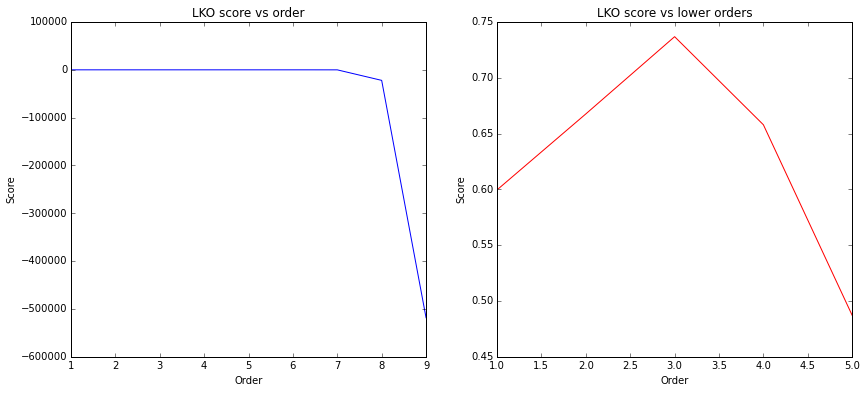

Polynomial order optimization executed in: 61.440601s


In [61]:
optimize_order(100, len(X), 4, X, Y)

In [62]:
get_scores(500,4,3,len(X),X,Y)

Average score of this model: 0.739524528107
Standard deviation of scores: 0.150738940559


###Measurement type has no effect on model performance.

#Conclusion:
The categorical variables don't appear to contribute at all to the variation within the data set. This may simply be because the vast majority of data points correspond to ceramic, perovskite samples. It may also be because the variation is actually captured by quantitative variables (including electron affinity and d-electron count) alone.

In the next notebook, I will analyze the rest of the quantitative variables to see if they have any significant impact.